In [39]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import os
%matplotlib inline

In [40]:
threshold_epsilon = 0.01
duration = 6
quantile_trim = [0.02, 0.98]
buckets = 10

In [41]:
def parse_data(filename):
    keys = ['Age', 'Height', 'Weight', 'Gender']
    with open(filename) as f:
        ## collect data from file
        result = {}
        for i in range(8):
            next(f)
        for i in keys:
            tmp = f.readline()
            result[i] = tmp[(tmp.index(' ') + 1):-1]
        for i in range(4):
            next(f)
        data = []
        for r in f:
            d = r[:-1].split(', ')
            data.append([float(i) for i in d])

        result['X_median'] = np.median([d[1] for d in data])
        result['Y_median'] = np.median([d[2] for d in data])
        result['Z_median'] = np.median([d[3] for d in data])     
        result['duration'] = data[-1][0] - data[0][0]
        ## standardizes Y data by median and X time to 0 second start
        data = list(map(lambda d : 
                        [(d[0] - data[0][0]) / 1000000000, 
                         d[1] - result['X_median'], 
                         d[2] - result['Y_median'], 
                         d[3] - result['Z_median']], 
                        data))

        x_data = [d[1] for d in data]
        x_min = min(x_data)
        x_max = max(x_data)  

        y_data = [d[2] for d in data]
        y_min = min(y_data)
        y_max = max(y_data)
        
        z_data = [d[3] for d in data]
        z_min = min(z_data)
        z_max = max(z_data)
        
        del x_data
        del y_data
        del z_data
        
        ## cuts off start and end
        data = trim_quantiles(data, quantile_trim)
        
        ## find threshold amount to trim
        threshold = min([abs(x_max - x_min), abs(y_max - y_min), abs(z_max - z_min)]) * threshold_epsilon
        (l_trim, r_trim) = trim_threshold(data, threshold)
        result['data'] = data[l_trim:r_trim]
        
        ## trim remaining data if still greater than desired duration, otherwise expand out to fill data
        
    return result, (l_trim, r_trim)

In [42]:
def trim_quantiles(data, quantiles):
    return data[int(len(data) * quantiles[0]):int(len(data) * quantiles[1])]

In [43]:
def trim_threshold(data, threshold):
    l_trim = 0
    is_significant = False
    while not is_significant and l_trim < len(data) - 2:
        dt = data[l_trim][0] - data[l_trim + 1][0]
        dx = data[l_trim][1] - data[l_trim + 1][1]
        dy = data[l_trim][2] - data[l_trim + 1][2]
        dz = data[l_trim][3] - data[l_trim + 1][3]
        if (abs(dx/dt) > threshold
        or abs(dy/dt) > threshold
        or abs(dz/dt) > threshold):
            is_significant = True
        else:
            l_trim += 1
            
    r_trim = len(data) - 1
    is_significant = False
    while not is_significant and r_trim > 1:
        dt = data[r_trim][0] - data[r_trim - 1][0]
        dx = data[r_trim][1] - data[r_trim - 1][1]
        dy = data[r_trim][2] - data[r_trim - 1][2]
        dz = data[r_trim][3] - data[r_trim - 1][3]
        if (abs(dx/dt) > threshold
        or abs(dy/dt) > threshold
        or abs(dz/dt) > threshold):
            is_significant = True
        else:
            r_trim -= 1
            
    return (l_trim, r_trim)

In [52]:
def plot_data(data, bounds=None):
    n = len(data['data'])
    Xs = [data['data'][i][0] for i in range(n)]
    Ys = [data['data'][i][1] for i in range(n)]
    plt.plot(Xs, Ys, c="r")
    Ys = [data['data'][i][2] for i in range(n)]
    plt.plot(Xs, Ys, c="g")
    Ys = [data['data'][i][3] for i in range(n)]
    plt.plot(Xs, Ys, c="b")
    if bounds is not None:
        y_bounds = list(plt.gca().get_ylim())
        plt.plot([data['data'][bounds[0]][0], data['data'][bounds[0]][0]], y_bounds, c='black')
        plt.plot([data['data'][bounds[1]][0], data['data'][bounds[1]][0]], y_bounds, c='grey')
    plt.show()

In [53]:
## edward wrote this, michael wrote everything else
def get_files(root_dir):
    result = [root_dir + file for file in os.listdir(root_dir) if not os.path.isdir(root_dir+file)]
    for file in [file for file in os.listdir(root_dir) if os.path.isdir(root_dir+file)]:
        result = result + get_files(root_dir + file + '/')
    return result

In [54]:
def load(root='./MobiFall/', plot=False):
    root_dir = root
    categories = {}
    for file in [file for file in get_files(root_dir) if file[-4:] == '.txt' and file[-6] == '_']:
        prefix = os.path.basename(file)[0:3]
        if prefix not in categories:
            obj = []
            categories[prefix] = obj
        result, domain = parse_data(file)
        categories[prefix].append(result)
        if plot:
            plot_data(result, domain)
    return categories

1919 (0, 1919)


IndexError: list index out of range

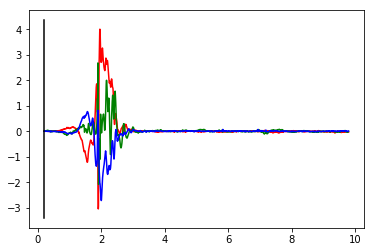

In [55]:
# categorizes by movement type. each movement contains a list of every datapoint for:
# categories['STN']['durations']: list of the lengths of each trimmed datapoint in STN
# categories['STN']['starts']: list of starting times
# categories['STN']['ends']: list of end times
categories = load('MobiFall_Small/', True)

In [ ]:
lst = []
for cat in categories.keys():
    for c in categories[cat]:
        lst.append(c['duration'])
        
## most points lie in ~6 billion as the duration
plt.hist(lst)

6000000000